In [28]:

# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
import numpy as np
import itertools
# Append module directory for imports
parent_dir = os.path.expanduser('../eigenestimation')
sys.path.append(parent_dir)

from toy_models.tms import AutoencoderSymmetric, GenerateTMSData, GenerateTMSDataParallel, AutoencoderParallel  # Import your model
from evaluation.networks import DrawNeuralNetwork
from eigenmodel.eigenmodel import EigenModel
from utils.loss import MSELoss
from utils.uniform_models import ZeroOutput

from toy_models.parallel_serial_network import CustomMLP
from torch import Tensor



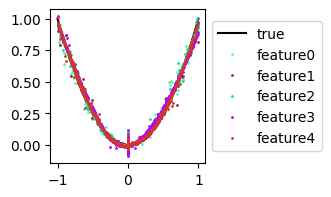

In [30]:
# Load model and data
model_path = "../outputs/toy_models/squared.pt"
model = torch.load(model_path)['model']
n_features = model.layers[0].in_features

X, _ = GenerateTMSData(num_features=n_features, num_datapoints=10000, sparsity=.05, batch_size=32)
X = X * (2*torch.rand_like(X).round() - 1)
#X = X[(X!=0).sum(dim=-1)==1,:]
Y = X**2
Y_pred = model(X)

plt.figure(figsize=(2,2))
np.random.seed(42)

X_true = np.linspace(-1,1,1000)
Y_true = X_true**2
plt.plot(X_true, Y_true, 'k-', label='true')


for i in range(X.shape[1]):
    # Pick a random color
    color = np.random.rand(3,)
    plt.plot(X[:, i].cpu().detach().numpy(), Y_pred[:,i].cpu().detach().numpy(), '.', markersize=2, color=color, label=f"feature{i}")
    
# Put legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
    

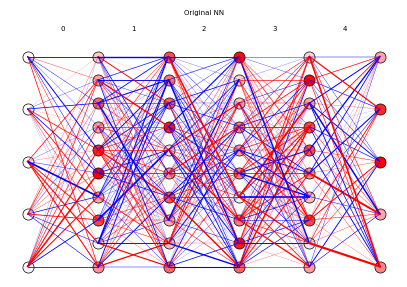

In [31]:
model_params = dict(model.named_parameters())
weights = {k:v for k,v in model_params.items() if 'bias' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'bias' in k}
biases = {str(i):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases, "Original NN")

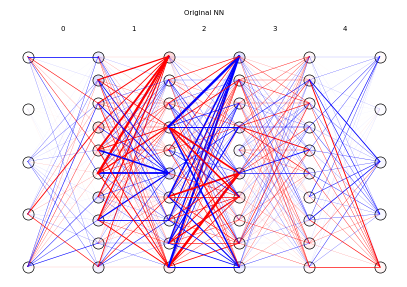

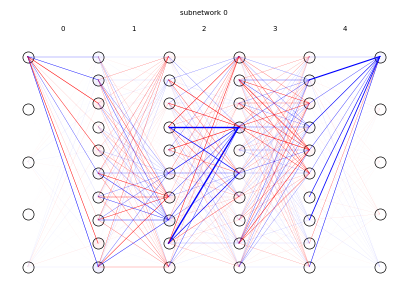

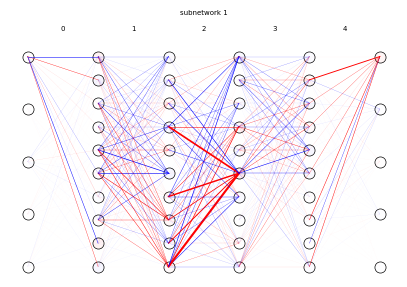

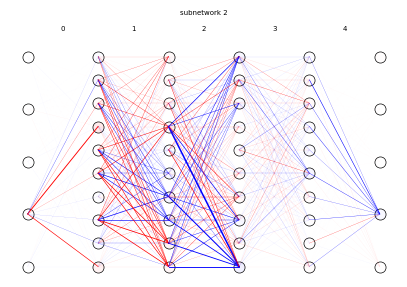

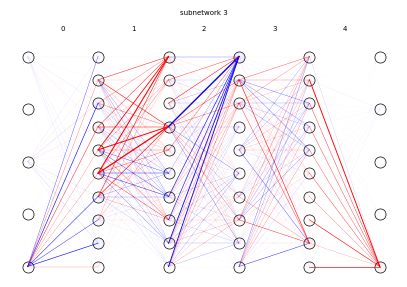

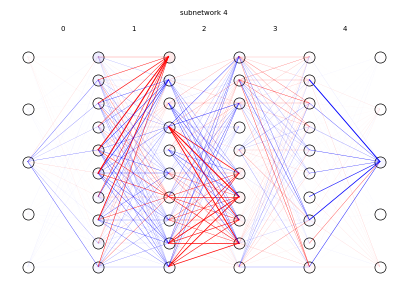

In [32]:
eigenmodel_path = "../outputs/eigenmodels/squared.pt"

checkpoint = torch.load(eigenmodel_path)
eigenmodel = checkpoint['model']

model_params = eigenmodel.reconstruct_network()
weights = {k:v for k,v in model_params.items() if 'bias' not in k}
weights = {str(i):10*v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'bias' in k}
biases = {str(i):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases, "Original NN")

for i, network in enumerate(eigenmodel.construct_subnetworks()):
    
    weights = {k:v for k,v in network.items() if 'bias' not in k}
    weights = {str(i):10*v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'bias' in k}
    biases = {str(i):v for i,v in enumerate(biases.values())}

    f = DrawNeuralNetwork(weights, biases, f"subnetwork {i}")
    # Save figure
    f.savefig(f'../figures/squared_subnetworks/squared_subnetwork_{i}.svg', bbox_inches='tight', transparent=True)
    
    
    


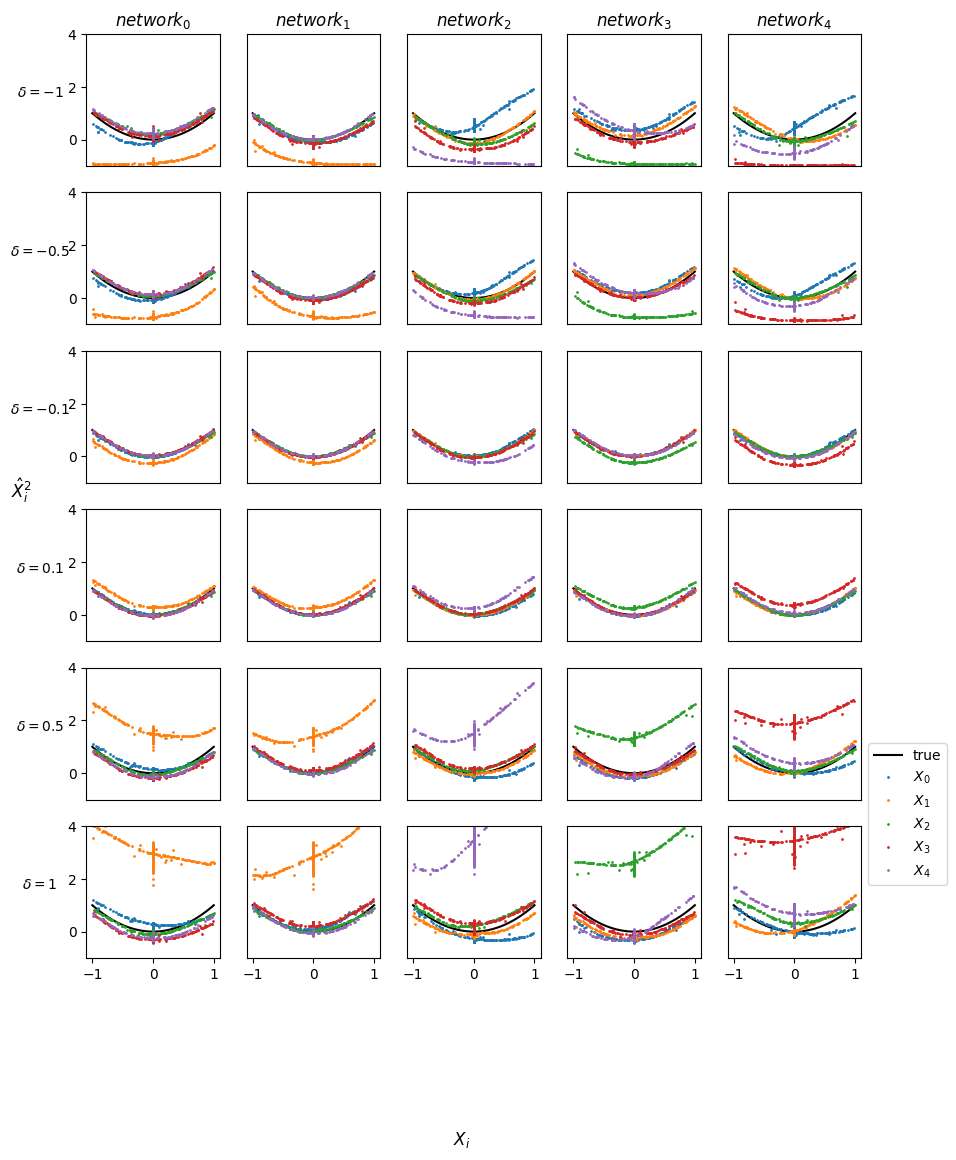

In [23]:
def PerturbAndGraph(delta_values, filename, X, ylim=(-1,2),):
    feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
    toy_model = copy.deepcopy(eigenmodel.model)
    orig_y = toy_model(X)
    f, ax = plt.subplots(len(delta_values),5, figsize=(10,2*len(delta_values)))
    for col_i, feature_idx in enumerate(range(5)):
        for row_i, feature_coeff in enumerate(delta_values):
            # Subplot with 2 columns
            feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
            feature_coefficients[feature_idx] = feature_coeff
            reconstruction = eigenmodel.add_to_network(feature_coefficients)
            # Repalce toy model parameters with model_params
            toy_model.load_state_dict(reconstruction)
            y = (toy_model(X) ).cpu().detach().numpy()
            ax[row_i,col_i].plot(np.linspace(-1,1,100), np.linspace(-1,1,100)**2, 'k-', label='true')
            for i in range(y.shape[1]):
                ax[row_i,col_i].plot(X[:,-i].cpu().detach().numpy(), y[:,-i], '.', label=f"${{X}}_{i}$",  markersize=2) #, bins=np.linspace(-.1,.1,100), alpha=.5)
                ax[row_i,col_i].set_ylim(ylim)

            ax[0,col_i].set_title(f"$network_{col_i}$")
            ax[0,col_i].set_xticks([])
            # If column is not 0, remove y ticks
            if col_i != 0:
                ax[row_i,col_i].set_yticks([])
                
            if row_i != len(delta_values)-1:
                ax[row_i,col_i].set_xticks([])


    # Set over all figure x and y axes
    f.supylabel('$\hat{X}_{i}^2$', rotation=0, x=.05)
    # Move sup y label closer to the figure

    for i, delta_value in enumerate(delta_values):
        ax[i,0].set_ylabel(f'$\delta={delta_value}$', rotation=0, labelpad=20)


    f.supxlabel('${X}_{i}$', rotation=0, y=-.05)
            
            
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

    # Save figure
    plt.savefig(filename, bbox_inches='tight', transparent=True)
    plt.show()


PerturbAndGraph([-1,-.5,-.1,.1, .5,1], '../figures/squared_intervention/squared_intervention_-1_1.pdf', X[:500],ylim=(-1,4))

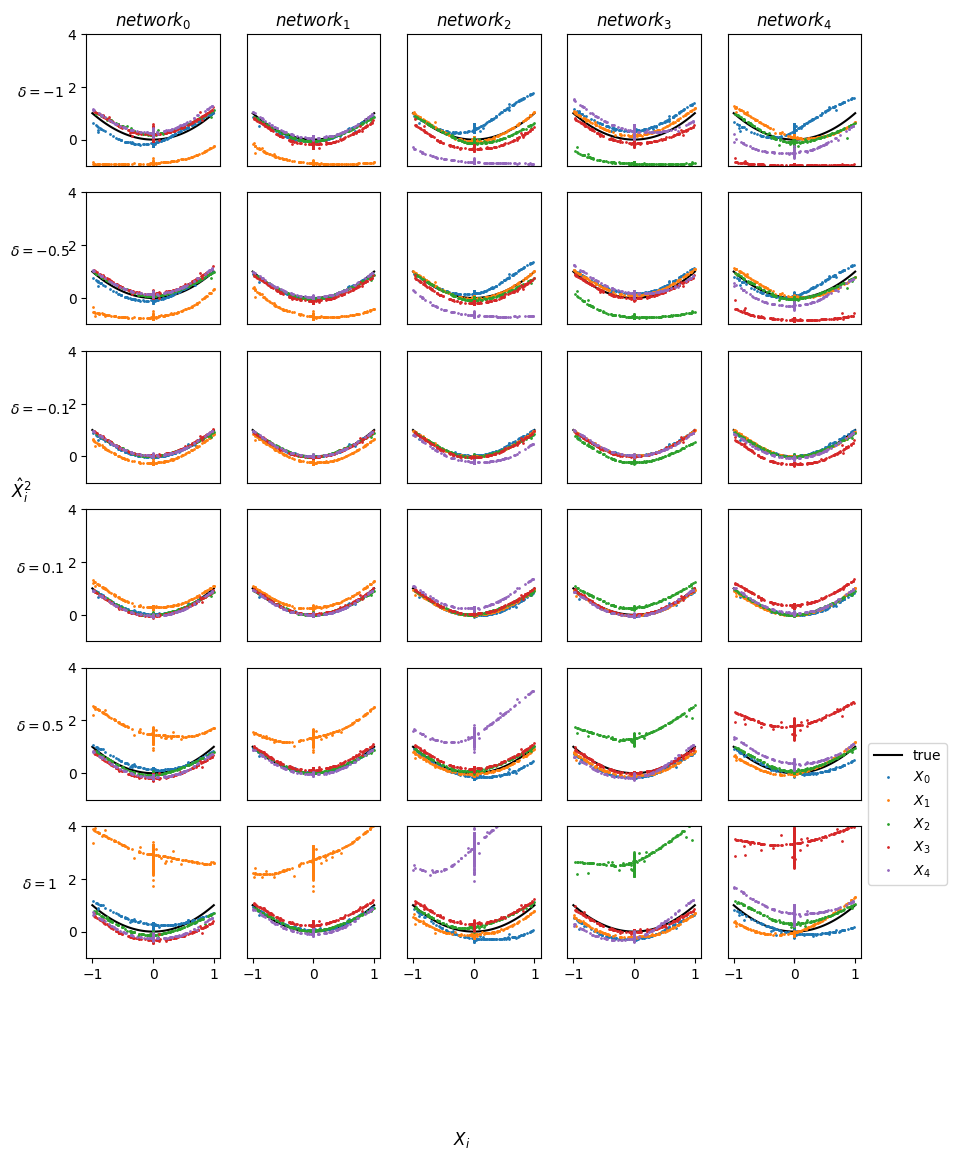

In [25]:
for name in eigenmodel.low_rank_decode:
    if '0.' in name or ('.4' in name):
        eigenmodel.low_rank_decode[name] = [torch.zeros_like(vec) for vec in eigenmodel.low_rank_decode[name]]
        
        eigenmodel.low_rank_encode[name] = [torch.zeros_like(vec) for vec in eigenmodel.low_rank_encode[name]]
        
        
PerturbAndGraph([-1,-.5,-.1,.1, .5,1], '../figures/squared_intervention/squared_intervention_just_middle_-1_1.pdf', X[:500],ylim=(-1,4))